In [86]:
import warnings

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import numpy as np
import seaborn as sns

from sklearn.pipeline import Pipeline

from preprocess_sunshine import sunshine_transformer
from preprocess_raintomorrow import raintomorrow_transformer
from preprocess_date import preprocess_date_transformer
from preprocess_temp import preprocess_temp
from preprocess_rainfall_raintoday import rainfall_raintoday_transformer
from preprocess_wind import wind_speed_transformer, wind_dir_transformer
from preprocess_humidity_pressure import VoisinageNAImputer

from sklearn.preprocessing import MinMaxScaler

from sklearn.ensemble import RandomForestClassifier
from sklearn.calibration import IsotonicRegression

from sklearn.neighbors import KNeighborsClassifier

from sklearn.calibration import calibration_curve
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, f1_score, brier_score_loss, roc_curve, roc_auc_score, precision_recall_curve, recall_score, precision_score, log_loss


In [ ]:
# def preprocessing(url_data : str = '../data/weatherAUS.csv', city : str = 'Sydney'):

warnings.filterwarnings('ignore')

df = pd.read_csv('../data/weatherAUS.csv')

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = 'Albury'

df = df[df['Location'].isin([city])]

columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

# print('colonne drop', columns_to_drop)
# print('colonne du dataframe', df.columns)

transformers = []

if 'Sunshine' not in columns_to_drop:
    transformers.append(('sunshine_transformer', sunshine_transformer()))
if 'RainTomorrow' not in columns_to_drop:
    transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
if 'Date' not in columns_to_drop:
    transformers.append(('date_transformer', preprocess_date_transformer()))
for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
    if temp_col not in columns_to_drop:
        transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
    if wind_col not in columns_to_drop:
        transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
    if wind_dir_col not in columns_to_drop:
        transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
if 'Rainfall' not in columns_to_drop:
    transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
for humidity_col in ['Humidity9am', 'Humidity3pm']:
    if humidity_col not in columns_to_drop:
        transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
for pressure_col in ['Pressure9am', 'Pressure3pm']:
    if pressure_col not in columns_to_drop:
        transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

df_transformed = Pipeline(transformers).fit_transform(df)

df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
df = df.set_index('Date')
print(df.columns)

df.dropna(inplace = True)
# print('apres', df.info())


Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow',
       'lag_raintomorrow', 'year', 'sin_months', 'cos_months', 'MinTemp_diff',
       'MaxTemp_diff', 'Temp9am_diff', 'Temp3pm_diff', 'WindGustSpeed_diff',
       'WindSpeed9am_diff', 'WindSpeed3pm_diff', 'WindGustDir_cos',
       'WindGustDir_sin', 'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos',
       'WindDir3pm_sin'],
      dtype='object')


In [110]:
X = df.drop(columns = 'RainTomorrow')
y = df['RainTomorrow']

X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

scaler = MinMaxScaler(feature_range = (-1, 1))
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

poids = y_train.value_counts(normalize = True)


model = RandomForestClassifier(
            n_estimators = 755,
            max_depth = 8,
            max_features = 'sqrt',
            min_samples_split = 3,
            min_samples_leaf = 15,
            criterion = 'gini',
            bootstrap = True,
            class_weight={0: 1/poids[0], 1: 1/poids[1]},
            random_state=42,
        )

model.fit(X_train_scaled, y_train)

print(y_train.value_counts(normalize = True))
print(y_train.value_counts())

prob = model.predict_proba(X_test_scaled)

y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
if y_train.value_counts(normalize = True)[1] > 0.30:
    threshold = 0.85
else:
    precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
    diff = abs(precision - recall)
    threshold = thresholds[diff.argmin()]
print(threshold)


y_pred = (y_pred_prob1 > threshold).astype(int)


print('score accuracy : ', model.score(X_test_scaled, y_test))
print('f1 score : ', f1_score(y_test, y_pred))
print('roc-auc score : ', roc_auc_score(y_test, y_pred))
print('brier score : ', brier_score_loss(y_test, y_pred), '\n\n')

print(confusion_matrix(y_test, y_pred), '\n\n')
print(classification_report(y_test, y_pred))

RainTomorrow
0.0    0.79517
1.0    0.20483
Name: proportion, dtype: float64
RainTomorrow
0.0    1778
1.0     458
Name: count, dtype: int64
0.5782752855895313
score accuracy :  0.8083109919571045
f1 score :  0.5967213114754099
roc-auc score :  0.7459522313703447
brier score :  0.1648793565683646 


[[532  61]
 [ 62  91]] 


              precision    recall  f1-score   support

         0.0       0.90      0.90      0.90       593
         1.0       0.60      0.59      0.60       153

    accuracy                           0.84       746
   macro avg       0.75      0.75      0.75       746
weighted avg       0.83      0.84      0.83       746



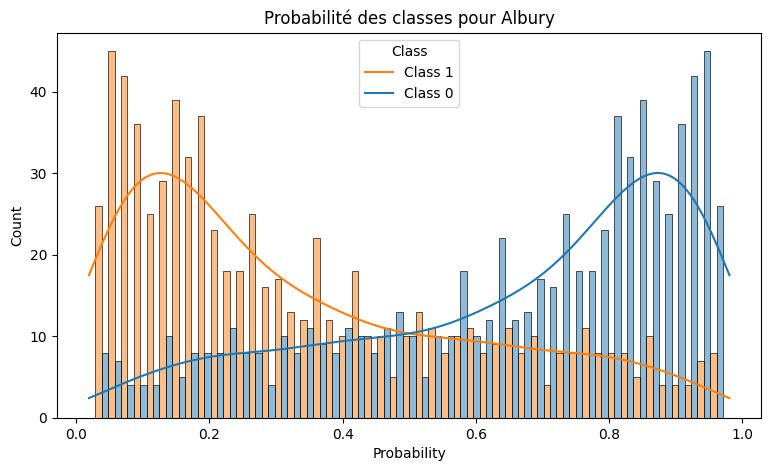

In [108]:
# y_pred_prob = model.predict_proba(X_test_scaled)
# probs_inverted = 1 - probs_scaled
# probs_normalized_1 = probs_inverted / np.max(probs_inverted)


plt.figure(figsize = (20, 5))
plt.subplot(121)
sns.histplot(prob, bins = 50, kde = True,
             stat = 'count', multiple = 'dodge',
             color = ['yellow', 'blue'])
plt.xlabel('Probability')
plt.legend(title='Class', labels=['Class 1', 'Class 0'], loc='upper center')
plt.title(f'Probabilité des classes pour {city}')
plt.show()


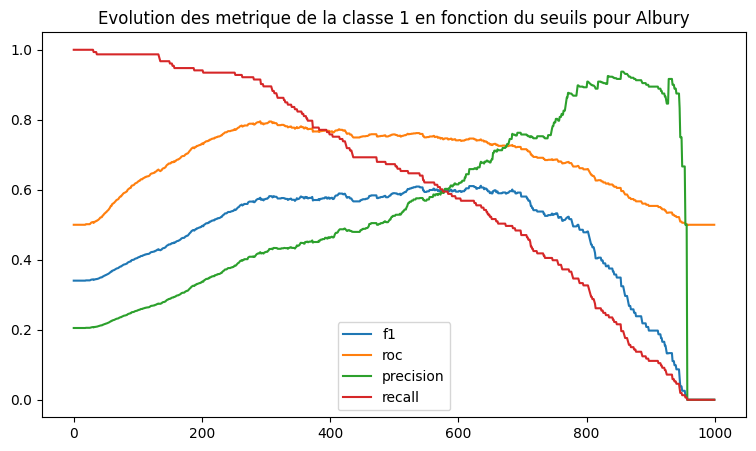

In [109]:
f1_1 = []
roc_1 = []
precision1 = []
recall1 = []

for i in np.linspace(0, 1, 1000):

    seuil = i

    y_pred = (y_pred_prob1 > i).astype("int32")

    f1_1.append(f1_score(y_test, y_pred))
    roc_1.append(roc_auc_score(y_test, y_pred))
    precision1.append(precision_score(y_test, y_pred))
    recall1.append(recall_score(y_test, y_pred))

plt.figure(figsize = (20, 5))

plt.subplot(121)
plt.plot(f1_1, label = 'f1')
plt.plot(roc_1, label = 'roc')
plt.plot(precision1, label = 'precision')
plt.plot(recall1, label = 'recall')
plt.title(f'Evolution des metrique de la classe 1 en fonction du seuils pour {city}')
plt.legend()

plt.show()

In [94]:
df = pd.read_csv('../data/weatherAUS.csv')


print(df['Location'].unique())

['Albury' 'BadgerysCreek' 'Cobar' 'CoffsHarbour' 'Moree' 'Newcastle'
 'NorahHead' 'NorfolkIsland' 'Penrith' 'Richmond' 'Sydney' 'SydneyAirport'
 'WaggaWagga' 'Williamtown' 'Wollongong' 'Canberra' 'Tuggeranong'
 'MountGinini' 'Ballarat' 'Bendigo' 'Sale' 'MelbourneAirport' 'Melbourne'
 'Mildura' 'Nhil' 'Portland' 'Watsonia' 'Dartmoor' 'Brisbane' 'Cairns'
 'GoldCoast' 'Townsville' 'Adelaide' 'MountGambier' 'Nuriootpa' 'Woomera'
 'Albany' 'Witchcliffe' 'PearceRAAF' 'PerthAirport' 'Perth' 'SalmonGums'
 'Walpole' 'Hobart' 'Launceston' 'AliceSprings' 'Darwin' 'Katherine'
 'Uluru']


In [ ]:
df_1 = pd.read_csv('../data/weatherAUS.csv')

list_city = []
list_accuracy = []
list_f1 = []
list_recall = []
list_precision = []
list_roc = []

# print(df['Location'].unique(), end = '\n\n')

# while True:

#     city = input('Quelle ville choisissez vous ?\n ---->\n\n').capitalize()

#     if city in df['Location'].unique():
#         break  # La ville est valide, on sort de la boucle
#     else:
#         print(f"La ville '{city}' n'est pas dans la liste. \n\n Veuillez choisir une ville parmi celles disponibles.")

city = df_1['Location'].unique()

for i in city:
    print(i)

    df = df_1[df_1['Location'].isin([i])]

    columns_to_drop = [col for col in df.columns if df[col].isna().mean() > 0.30]

    # print('colonne drop', columns_to_drop)
    # print('colonne du dataframe', df.columns)

    transformers = []

    if 'Sunshine' not in columns_to_drop:
        transformers.append(('sunshine_transformer', sunshine_transformer()))
    if 'RainTomorrow' not in columns_to_drop:
        transformers.append(('raintomorrow_transformer', raintomorrow_transformer()))
    if 'Date' not in columns_to_drop:
        transformers.append(('date_transformer', preprocess_date_transformer()))
    for temp_col in ['MinTemp', 'MaxTemp', 'Temp9am', 'Temp3pm']:
        if temp_col not in columns_to_drop:
            transformers.append((f'{temp_col.lower()}_transformer', preprocess_temp(col_select=temp_col)))
    for wind_col in ['WindGustSpeed', 'WindSpeed9am', 'WindSpeed3pm']:
        if wind_col not in columns_to_drop:
            transformers.append((f'{wind_col.lower()}_transformer', wind_speed_transformer(col_select=wind_col)))
    for wind_dir_col in ['WindGustDir', 'WindDir9am', 'WindDir3pm']:
        if wind_dir_col not in columns_to_drop:
            transformers.append((f'{wind_dir_col.lower()}_transformer', wind_dir_transformer(col_select=wind_dir_col)))
    if 'Rainfall' not in columns_to_drop:
        transformers.append(('rainfall_transformer', rainfall_raintoday_transformer(city=city)))
    for humidity_col in ['Humidity9am', 'Humidity3pm']:
        if humidity_col not in columns_to_drop:
            transformers.append((f'{humidity_col.lower()}_imputer', VoisinageNAImputer(column=humidity_col)))
    for pressure_col in ['Pressure9am', 'Pressure3pm']:
        if pressure_col not in columns_to_drop:
            transformers.append((f'{pressure_col.lower()}_imputer', VoisinageNAImputer(column=pressure_col)))

    df_transformed = Pipeline(transformers).fit_transform(df)

    df = df.drop(columns = ['Location', 'WindGustDir', 'WindDir9am', 'WindDir3pm'] + columns_to_drop)
    df = df.set_index('Date')
    print(df.columns)

    df.dropna(inplace = True)


    X = df.drop(columns = 'RainTomorrow')
    y = df['RainTomorrow']

    X_train, X_test, y_train, y_test = train_test_split(X, y, random_state = 42, stratify = y)

    scaler = MinMaxScaler(feature_range = (-1, 1))
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)

    poids = y_train.value_counts(normalize = True)


    model = RandomForestClassifier(
                n_estimators = 755,
                max_depth = 8,
                max_features = 'sqrt',
                min_samples_split = 3,
                min_samples_leaf = 15,
                criterion = 'gini',
                bootstrap = True,
                class_weight={0: 1/poids[0], 1: 1/poids[1]},
                random_state=42,
            )

    model.fit(X_train_scaled, y_train)

    print(y_train.value_counts(normalize = True))
    print(y_train.value_counts())

    prob = model.predict_proba(X_test_scaled)

    y_pred_prob1 = model.predict_proba(X_test_scaled)[:, 1]

    if y_train.value_counts(normalize = True)[1] < 0.15:
        threshold = 0.165
    if y_train.value_counts(normalize = True)[1] > 0.30:
        threshold = 0.85
    else:
        precision, recall, thresholds = precision_recall_curve(y_test, y_pred_prob1)
        diff = abs(precision - recall)
        threshold = thresholds[diff.argmin()]
    print(threshold)


    y_pred = (y_pred_prob1 > threshold).astype(int)

    list_city.append(i)

    list_accuracy.append(model.score(X_test_scaled, y_test))
    list_f1.append(f1_score(y_test, y_pred))
    list_roc.append(roc_auc_score(y_test, y_pred))
    list_precision.append(precision_score(y_test, y_pred))
    list_recall.append(recall_score(y_test, y_pred))


Albury
Pas de station à moins de 50 km de Albury
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow',
       'lag_raintomorrow', 'year', 'sin_months', 'cos_months', 'MinTemp_diff',
       'MaxTemp_diff', 'Temp9am_diff', 'Temp3pm_diff', 'WindGustSpeed_diff',
       'WindSpeed9am_diff', 'WindSpeed3pm_diff', 'WindGustDir_cos',
       'WindGustDir_sin', 'WindDir9am_cos', 'WindDir9am_sin', 'WindDir3pm_cos',
       'WindDir3pm_sin'],
      dtype='object')
RainTomorrow
0.0    0.79517
1.0    0.20483
Name: proportion, dtype: float64
RainTomorrow
0.0    1778
1.0     458
Name: count, dtype: int64
0.5782752855895313
BadgerysCreek
Index(['MinTemp', 'MaxTemp', 'Rainfall', 'WindGustSpeed', 'WindSpeed9am',
       'WindSpeed3pm', 'Humidity9am', 'Humidity3pm', 'Pressure9am',
       'Pressure3pm', 'Temp9am', 'Temp3pm', 'RainToday', 'RainTomorrow

In [120]:
df_global = pd.DataFrame({
    'location' : list_city,
    'accurcy' : list_accuracy,
    'f1': list_f1,
    'roc' : list_roc,
    'precision' : list_precision,
    'recall' : list_recall}
)

df_global.set_index('location', inplace = True)

df_global.mean(axis = 0)

accurcy      0.829745
f1           0.585073
roc          0.741185
precision    0.678763
recall       0.561169
dtype: float64

In [122]:
df_global.median(axis = 0)

accurcy      0.823920
f1           0.611765
roc          0.754364
precision    0.650794
recall       0.609375
dtype: float64